# Daten: Vorverarbeiten, Transformieren & Extrahieren

## Das Gelernte anwenden.

Ziel der Aufgaben dieses Notebooks ist es, ein automatisiertes System zur Erkennung von Brustkrebs zu erstellen. Als Datengrundlage steht ein tabellarisches Datenset zur Verfügung, welches auf Kennzahlen, berechnet aus Gewebeproben von gutartigen (engl. benign) sowie bösartigen (engl. malignant) Tumoren. Dieses Ziel wollen wir erreichen, indem wir einen einfachen Klassifikationsalgorithmus - den sog. Gaussian Naive Bayes Classifier (GNB) - auf diese Daten anwenden. So wollen wir erkennen, ob eine entnommene Gewebeprobe als gutartig ("0") oder bösartig ("1") einzustufen ist und damit weitere Behandlungsschritte aus dieser Klassifikation ableiten.

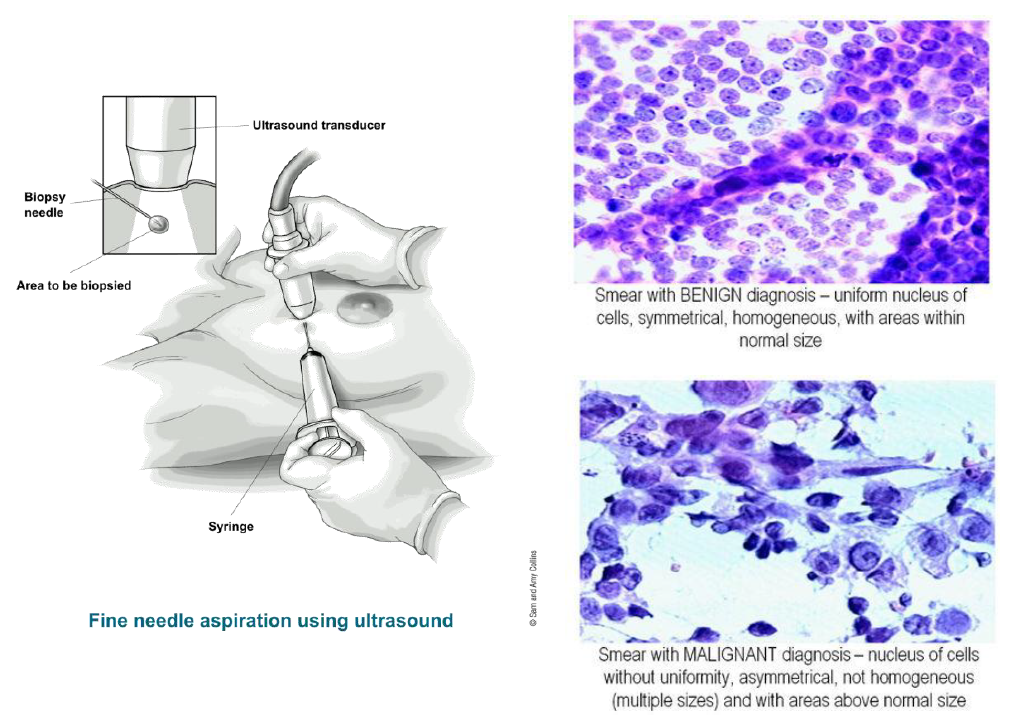

In ["Nuclear Feature Extraction For Breast Tumor Diagnosis”, SPIE, 1993](https://minds.wisconsin.edu/bitstream/handle/1793/59692/TR1131.pdf?sequence=1) geben die Autoren nähere Informationen zum Datenset und der Bedeutung der einzelnen Spalten preis.

Auch in diesem Teil des Workshops werden wir wieder auf die Module

* [pandas](https://pandas.pydata.org/docs/reference/index.html#api)
* [seaborn](https://seaborn.pydata.org/api.html)

setzen. Neu hinzu kommt [scikit-learn](https://scikit-learn.org/stable/modules/classes.html), das uns die Arbeit mit einfachen Modellen wie dem GNB erleichtert. Ein kurzes und lesenswertes (populärwissenschaftliches) Intro zur Theorie hinter GNB ist auf [towardsdatascience.com](https://towardsdatascience.com/naive-bayes-classifier-81d512f50a7c) zu finden.

Auch für komplexere Ansätze wie Support Vector Machines (SVMs) kann auf die Bibliothek [scikit-learn](https://scikit-learn.org/stable/modules/classes.html) zurückgegriffen werden. Eine SVM werden wir gegen Ende dieses Moduls trainieren, und deren Klassifikationsresultate, auch in Bezug auf die Ergebnisse der Klassifizierung mit GNB, genauer betrachten.

Abschließend kommt [TensorFlow](https://www.tensorflow.org/api_docs/python/tf) in Verbindung mit [Keras](https://keras.io/api/) zum Einsatz, um einen Einblick in das Design, das Training und die Evaluierung von neuronalen Netzen im Kontext binärer Klassifizierung von strukturierten (=tabellarischen) Daten geben zu können.

So lernen Sie in diesem Workshop Schritt für Schritt drei Modelltypen kennen, gestaffelt von einfach bis hochkomplex und anpassbar, die Sie später auf ihre eigenen Predictiontasks anwenden können.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import Callback, EarlyStopping, TensorBoard
from datetime import datetime

In [2]:
# Hilfsfunktion zum Anzeigen der Confusion Matrix, die ohne das Übergeben des Classifierobjekts funktioniert.
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    fig = plt.figure()

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=3, out=None)  
    
    
    thresh = cm.max() / 2.
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    fig.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
# Hilfsfunktion zum Visualisieren gelernter Entscheidungsgrenzen von SVMs
# Adaptiert von: https://stackoverflow.com/questions/51297423/plot-scikit-learn-sklearn-svm-decision-boundary-surface
def make_meshgrid(x, y, h=.05):
    x_min, x_max = x.min() - 5, x.max() + 5
    y_min, y_max = y.min() - 5, y.max() + 5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

## Teil 1: Explorative Datenanalyse

Bevor wir uns mit dem Trainieren eines Naive Bayes Classifiers befassen können, gilt es jene Schritte zu wiederholen, die bereits im Theorieteil zu diesem Workshop, sowie in den vorangeganenen Terminen, besprochen.
Das bedeutet: Wir beschäftigen uns ausführlich mit dem Datenset, versuchen die darin enthaltenen Daten zu verstehen und zu visualisieren und setzen anschließend das Säubern und Präprozessieren der Daten um.

### Aufgabe 0: Daten einlesen 

Aus dem Ordner `resources/data` soll die Datei `breast_cancer.csv` (Achtung: das verwendete Trennzeichen im Datensatz ist ein  Semikolon `;`) eingelesen werden.

In [4]:
df = pd.read_csv('../resources/data/breast_cancer.csv', sep=';')

In [5]:
df.head(5)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,malignant
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,malignant
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,malignant
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,malignant
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,malignant


### Aufgabe 1: Die Struktur des Datensatzes verstehen

* Ist der Datensatz vollständig?
* Welche Spalte des Datensatzes ist die Zielvariable unserer geplanten Vorhersage?
* In welchem Datentyp ist diese Zielvariable hinterlegt?
* In welche Klassen ist die Zielvariable aufgeteilt und wieviele Samples sind für jede der Klassen aufgezeichnet?
* Wie steht es um die Verteilung der Variablen, die in den einzelnen Spalten ausgewiesen werden?
    * Hier würde sich eine Untersuchung der Spalten per Boxplot bzw. Violinenplot anbieten.
* Um ein tieferes Verständnis der Bedeutung einzelner Zahlenwerte und ihrer Aussagekraft bei der Bestimmung von Tumorarten zu erhalten kann auch ein Blick in die Ursprungspublikation des Datensatzes (am Anfang des Notebooks verlinkt) helfen.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [7]:
df['diagnosis']

0      malignant
1      malignant
2      malignant
3      malignant
4      malignant
         ...    
564    malignant
565    malignant
566    malignant
567    malignant
568       benign
Name: diagnosis, Length: 569, dtype: object

In [8]:
df['diagnosis'].unique()

array(['malignant', 'benign'], dtype=object)

In [9]:
df.groupby('diagnosis').size()

diagnosis
benign       357
malignant    212
dtype: int64

In [10]:
df.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


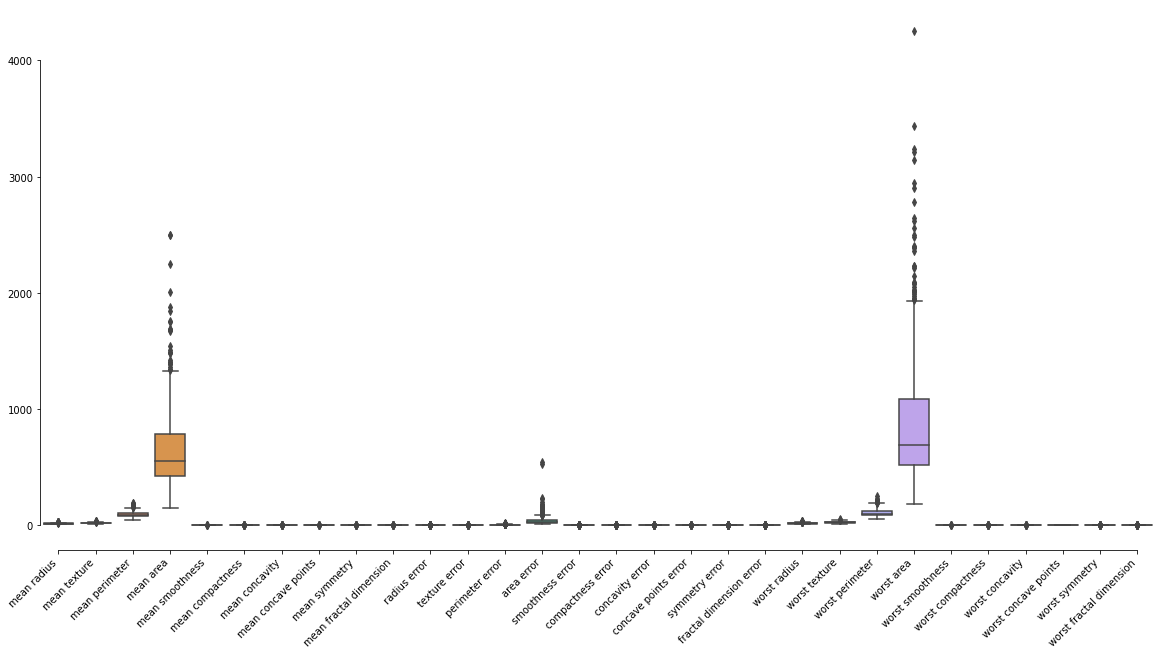

In [11]:
plt.figure(figsize=(20,10))
sns.boxplot(data=df)
sns.despine(offset=0, trim=True)

plt.xticks(
    rotation=45,
    horizontalalignment='right',
    fontweight='light'
);

### Aufgabe 2: Zusammenhänge zwischen den einzelnen Spalten visualisieren

Im nächsten Schritt wird untersucht, wie die einzelnen Variablen zueinander stehen. Außerdem wollen wir erkennen, welche Spalten eine hohe (negative oder positive) Korrelation mit unserer Zielvariable aufweisen. Hierzu ist eine Korrelationsmatrix zu berechnen (siehe die pandas DataFrame Methode [corr()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html) sowie die dazugehörige Visualisierung per seaborn [heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html)).

**Achtung: Solltet ihr die Zielvariable in diesem Plot anzeigen wollen, ist eine Konvertierung dieser Spalte in ein numerisches Format vorzunehmen!**

Hierzu bietet es sich an, sich an die Konventionen des medizinischen Settings zu halten und folgende Codierung anzuwenden:

- **Positiv bzw. "malignant" (1)**: Krankes Gewebe bzw. bösartiger Tumor
- **Negativ bzw. "benign" (0)**: Gesundes Gewebe bzw. gutartiger Tumor

In [12]:
df['diagnosis'] = [1 if label == 'malignant' else 0 for label in df['diagnosis']]

In [13]:
df['diagnosis']

0      1
1      1
2      1
3      1
4      1
      ..
564    1
565    1
566    1
567    1
568    0
Name: diagnosis, Length: 569, dtype: int64

C:\Users\Max\.virtualenvs\bc-workshop-data-science-Vsec5B-7\lib\site-packages\seaborn\utils.py:328: UserWarning: Use the colorbar set_ticks() method instead.
  ax_i.set_yticks(newticks)


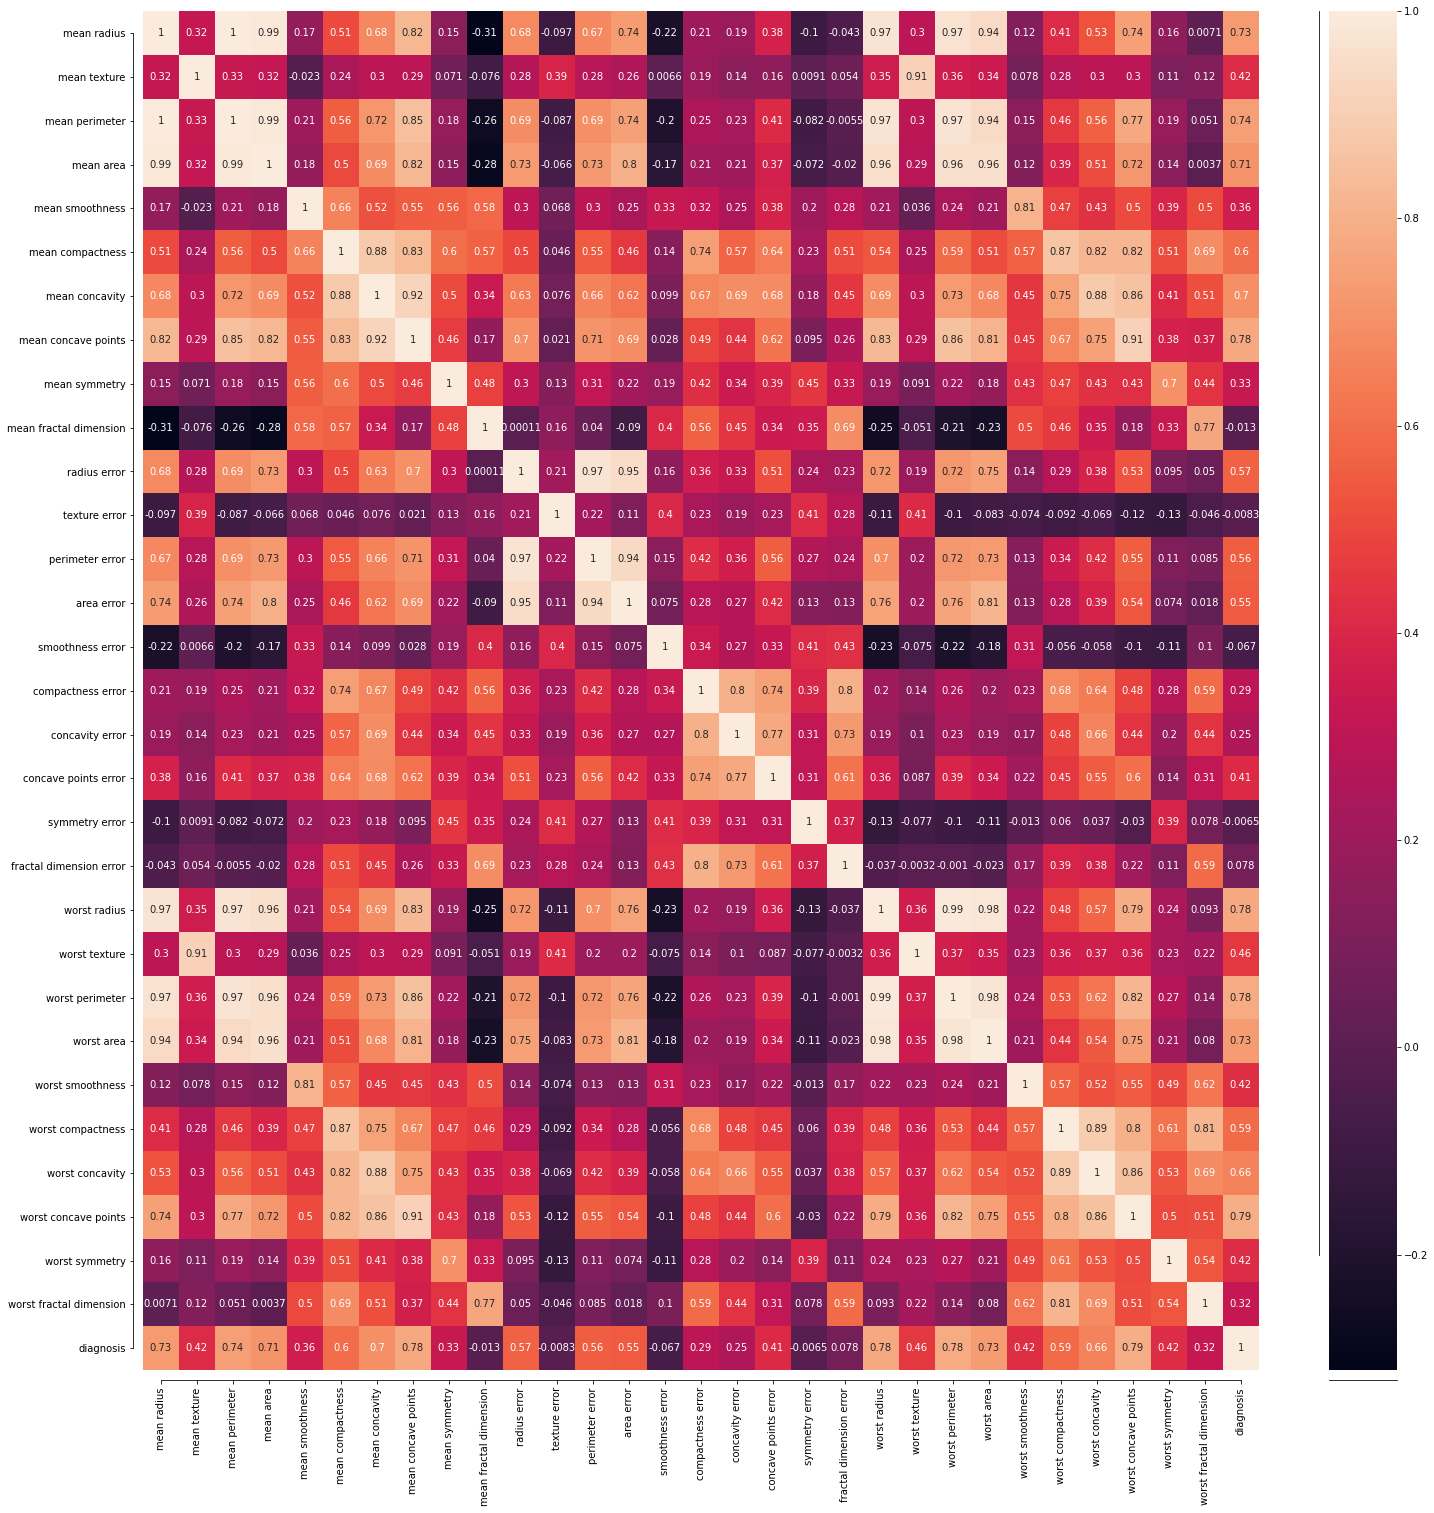

In [14]:
corr = df.corr()
plt.figure(figsize=(25,25))
sns.heatmap(corr, annot=True)
sns.despine(offset=10, trim=True)
plt.xticks(
    rotation=90
);

### Aufgabe 3: Feature Selection (optional)

Was können wir aus der Korrelationsmatrix ableiten? Welche Features sind besonders interessant bezogen auf die ausgewählte Zielvariable?

## Teil 2: Präprozessieren und Transformieren

Nach der eingehenden Analyse der Daten kümmern wir uns nun um das Vorbereiten der Daten für den Naive Bayes Classifier. Diese Arbeit umfasst das Skalieren, Transformieren und Extrahieren einzelner Spalten.

### Aufgabe 4: Extrahieren der Zielvariable
Zuerst wird der vorliegende DataFrame nun aufgeteilt. Hierzu speichern wir unsere Zielvariable in einer eigenen Variable (typischerweise **y**, engl. **labels**) ab. Anschließend speichern wir die **inputs** für das Modell in der Variable **X**. Diese bestehen entweder nur aus jenen Features, die wir in Aufgabe 3 vorselektiert haben, oder aus allen übrigen Spalten des DataFrames.

In [15]:
y = df['diagnosis']
X = df.drop(columns=['diagnosis'])

In [16]:
np.round(X.shape[0] * 0.33)

188.0

### Aufgabe 5: Aufteilen des Datensatzes per Train-Test-Split

Für die spätere Evaluierung der Modellperformance ist es zwingend erforderlich, einen Teil der Daten beiseite zu legen, und diesen somit nicht während des Modelltrainings zu verwenden.
Diese Aufgabe übernimmt typischerweise sklearn's Funktion [train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)

In [18]:
X_test.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
99,14.42,19.77,94.48,642.5,0.09752,0.11410,0.09388,0.05839,0.1879,0.06390,...,16.33,30.86,109.50,826.4,0.1431,0.3026,0.3194,0.15650,0.2718,0.09353
560,14.05,27.15,91.38,600.4,0.09929,0.11260,0.04462,0.04304,0.1537,0.06171,...,15.30,33.17,100.20,706.7,0.1241,0.2264,0.1326,0.10480,0.2250,0.08321
304,11.46,18.16,73.59,403.1,0.08853,0.07694,0.03344,0.01502,0.1411,0.06243,...,12.68,21.61,82.69,489.8,0.1144,0.1789,0.1226,0.05509,0.2208,0.07638
381,11.04,14.93,70.67,372.7,0.07987,0.07079,0.03546,0.02074,0.2003,0.06246,...,12.09,20.83,79.73,447.1,0.1095,0.1982,0.1553,0.06754,0.3202,0.07287
411,11.04,16.83,70.92,373.2,0.10770,0.07804,0.03046,0.02480,0.1714,0.06340,...,12.41,26.44,79.93,471.4,0.1369,0.1482,0.1067,0.07431,0.2998,0.07881


In [19]:
y_test.head()

99     1
560    0
304    0
381    0
411    0
Name: diagnosis, dtype: int64

### Aufgabe 6: Skalierung der Daten

Neben anderen (wichtigen) Annahmen zur Beschaffenheit der Daten ist bekannt, dass die Skalierung der Inputdaten, und damit die Angleichung der Wertebereiche einzelner Spalten, einen positiven Einfluss auf die Leistung des (Gaussian) Naive Bayes Classifiers haben kann.
In diesem Abschnitt nehmen wir diese Skalierung vor. Wie bereits im letzten Notebook gezeigt, wird hierfür sklearn's Klasse `StandardScaler`verwendet.

In [20]:
u = X_train['mean radius'].mean()
s = X_train['mean radius'].std()

In [21]:
X_test['mean radius']

99     14.42
560    14.05
304    11.46
381    11.04
411    11.04
       ...  
320    10.25
382    12.05
98     11.60
216    11.89
73     13.80
Name: mean radius, Length: 188, dtype: float64

In [22]:
(X_test['mean radius'] - u) / s

99     0.083783
560   -0.020583
304   -0.751143
381   -0.869612
411   -0.869612
         ...   
320   -1.092447
382   -0.584722
98    -0.711653
216   -0.629853
73    -0.091100
Name: mean radius, Length: 188, dtype: float64

In [23]:
sc = StandardScaler()

In [24]:
X_train_sc = pd.DataFrame(sc.fit_transform(X_train.values),
                          columns=X_train.columns,
                          index=X_train.index)

X_test_sc = pd.DataFrame(sc.transform(X_test.values),
                         columns=X_test.columns,
                         index=X_test.index)

In [25]:
X_train.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
435,13.98,19.62,91.12,599.5,0.10600,0.11330,0.112600,0.064630,0.1669,0.06544,...,17.040,30.80,113.9,869.3,0.16130,0.35680,0.40690,0.18270,0.3179,0.10550
47,13.17,18.66,85.98,534.6,0.11580,0.12310,0.122600,0.073400,0.2128,0.06777,...,15.670,27.95,102.8,759.4,0.17860,0.41660,0.50060,0.20880,0.3900,0.11790
326,14.11,12.88,90.03,616.5,0.09309,0.05306,0.017650,0.027330,0.1373,0.05700,...,15.530,18.00,98.4,749.9,0.12810,0.11090,0.05307,0.05890,0.2100,0.07083
307,9.00,14.40,56.36,246.3,0.07005,0.03116,0.003681,0.003472,0.1788,0.06833,...,9.699,20.07,60.9,285.5,0.09861,0.05232,0.01472,0.01389,0.2991,0.07804
551,11.13,22.44,71.49,378.4,0.09566,0.08194,0.048240,0.022570,0.2030,0.06552,...,12.020,28.26,77.8,436.6,0.10870,0.17820,0.15640,0.06413,0.3169,0.08032


In [26]:
X_train_sc.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
435,-0.040381,0.033897,-0.031333,-0.156492,0.688694,0.190037,0.289369,0.400686,-0.538702,0.374258,...,0.153872,0.786039,0.194832,-0.023754,1.209232,0.650305,0.622595,1.013328,0.402666,1.159640
47,-0.269157,-0.186397,-0.242351,-0.340508,1.363210,0.371827,0.411614,0.622347,1.134346,0.697609,...,-0.129022,0.324821,-0.135444,-0.217730,1.928369,1.025721,1.062782,1.403381,1.511097,1.829953
326,-0.003664,-1.512751,-0.076082,-0.108290,-0.199878,-0.927414,-0.871345,-0.542068,-1.617617,-0.797022,...,-0.157931,-1.285396,-0.266365,-0.234498,-0.170847,-0.893420,-1.039639,-0.836806,-1.256139,-0.714532
307,-1.446933,-1.163952,-1.458374,-1.157949,-1.785679,-1.333659,-1.042109,-1.145077,-0.104949,0.775324,...,-1.361986,-0.950406,-1.382162,-1.054177,-1.396706,-1.261177,-1.219800,-1.509460,0.113643,-0.324778
551,-0.845336,0.681011,-0.837225,-0.783395,-0.022990,-0.391691,-0.497398,-0.662377,0.777137,0.385360,...,-0.882718,0.374989,-0.879310,-0.787481,-0.977279,-0.470921,-0.554212,-0.758646,0.387292,-0.201526


In [27]:
y_test.head()

99     1
560    0
304    0
381    0
411    0
Name: diagnosis, dtype: int64

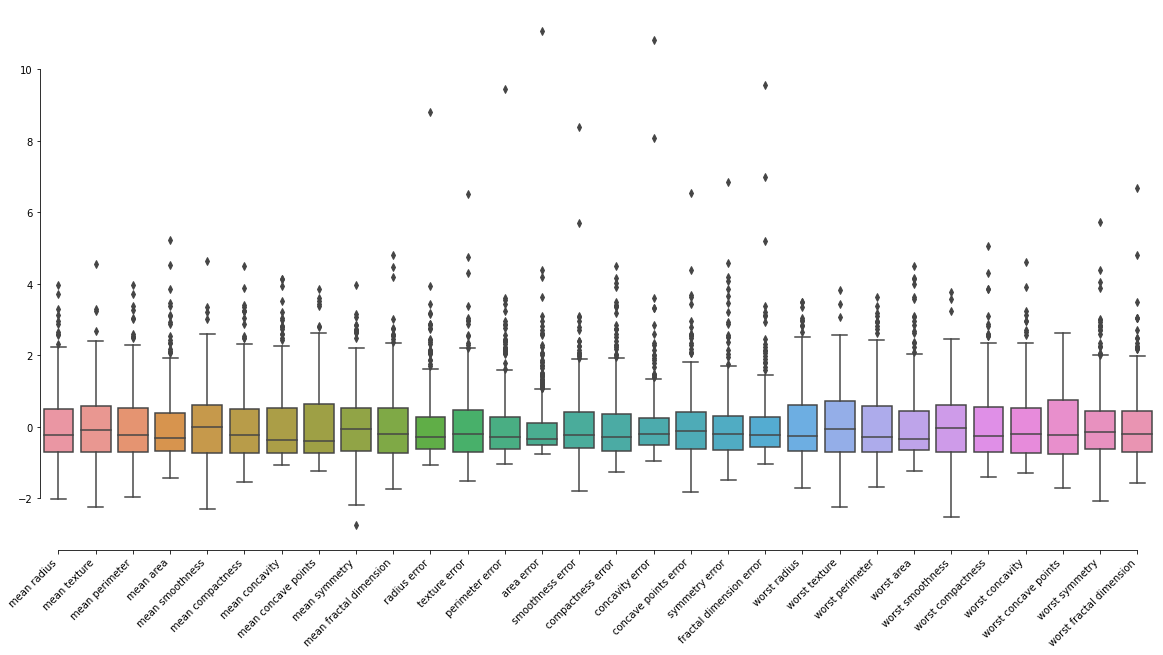

In [28]:
plt.figure(figsize=(20,10))
sns.boxplot(data=X_train_sc)
sns.despine(offset=0, trim=True)

plt.xticks(
    rotation=45,
    horizontalalignment='right',
    fontweight='light'
);

## Teil 3: Ein erstes eigenes Modell erstellen, trainieren und evaluieren

Nun geht's endlich an's Trainieren eines eigenen Modells! Sklearn stellt hierfür eine eigene Klasse (`GaussianNB`) bereit, die wir vorerst, ohne weitere Übergabeparameter mitzugeben, instanzieren.

### Aufgabe 7: Trainieren eines Gaussian Naive Bayes Classifiers auf Basis der Trainingsdaten
Das eigentliche Training wird über den Aufruf der Methode `fit()` gestartet, wobei hier die Trainingsdaten sowie die dazugehörigen Labels zu übergeben sind (**X_train** und **y_train**).

In [29]:
gnb = GaussianNB()

In [30]:
gnb.fit(X_train_sc, y_train);

### Aufgabe 8: Das trainierte Modell auf die Testdaten anwenden
Ein Aufruf der Methode `predict()` ermöglicht es uns nun, unser trainiertes Gaussian Naive Bayes Modell auf ungesehene Daten anzuwenden. Gut, dass wir einen Teil der Inputdaten bereits beiseite gelegt haben, welche in **X_test** abgespeichert sind. Dabei gibt die Methode `predict()`, angewandt auf **X_test**, nun Vorhersagen für jeden einzelnen Datenpunkt in **X_test** zurück.

In [31]:
y_pred = gnb.predict(X_test_sc)

### Aufgabe 9: Evaluierung der Vorhersagen
Da die in **y_test** abgespeicherten wahren Labels direkt mit den in **X_test** abgespeicherten Testdaten korrespondieren, und wir nun über vom Modell getätigte Vorhersagen für jeden einzelnen Datenpunkt in **X_test** verfügen, lässt sich über den Vergleich von Vorhersage zu wahrem Label die Modellperformance messbar machen. In einem ersten Schritt betrachten wir nur die Genauigkeit des Modells, die wir bspw. über sklearn's Funktion `accuracy_score()` berechnen können.

Zudem sollten wir uns nochmal die möglichen Resulate dieses Vergleichs von wahrem zu vorhergesagtem Label in Erinnerung rufen:

- **True positive (TP)**: Krankes Gewebe wurde korrekt als bösartiger Tumor erkannt.
- **False positive (FP)**: Gesundes Gewebe wurde fälschlicherweise als bösartiger Tumor erkannt.
- **True negative (TN)**: Gesundes Gewebe wurde korrekt als gutartig klassifiziert.
- **False negative (FN)**: Krankes Gewebe wurde fälschlicherweise als gesundes Gewebe klassifiziert.

In [32]:
acc = accuracy_score(y_test, y_pred)

print(f'Accuracy bzw. Genauigkeit:\t{acc:.3f}')

Accuracy bzw. Genauigkeit:	0.936


Nach der Berechnung der Genauigkeit, sollten wir uns nun die Ergebnisse der Vorhersage im Detail ansehen. Hierzu berechnen (per sklearn's `confusion_matrix`) und visualisieren wir die Confusion Matrix. 

In [33]:
cm = confusion_matrix(y_test, y_pred)

In [34]:
tp = cm[1, 1]
tn = cm[0, 0]
fp = cm[0, 1]
fn = cm[1, 0]

In [35]:
class_names = ['benign', 'malignant']

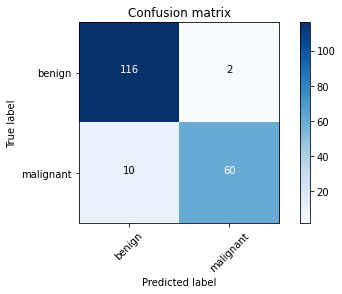

In [36]:
plot_confusion_matrix(cm, class_names)

### Aufgabe 10: Näheres Betrachten der Ergebnisse Sensitivität und Spezifizität

Um einen tieferen Einblick in die Güte des Klassifizierungsergebnisses zu bekommen, ziehen wir nun weitere Metriken heran, die bei der Evaluierung unseres automatisierten Systems zur Erkennung von Brustkrebs hilfreich sein können. Besonders herauszuheben ist hierbei die Metrik **Sensitivität**, die gerade im medizinischen Kontext, von hoher Bedeutung ist.

#### Sensitivität
Die Sensitivität beschreibt die Fähigkeit eines medizinischen Tests, kranke Patienten korrekt als krank zu identifizieren. Ein Krankheitserkennungssystem mit 100% Sensitivität erkennt also **alle** Patienten, die die getestete Krankheit auch tatsächlich haben.

$Sensitivity = True\,Positive\,Rate\,(TPR) = \frac{TP}{TP+FN}$

Welche Art des Fehlers fließt jedoch nicht in die Berechnung der Sensitivität ein?

Oder anders gefragt: wie zuverlässig ist nun ein positives Testergebnis eines Krankheitserkennungssystems mit 100% Sensitivität?

#### Spezifizität
Die Spezifizität hingegen beschreibt, mit welcher Rate ein medizinischer Test dazu in der Lage ist, gesunde Patienten korrekt als gesund zu identifizieren. Ein Krankheitserkennungssystem mit 100% Spezifizität würde somit **all jene** Patienten richtigerweise als gesund erkennen, die die getestete Krankheit **nicht** in sich tragen.

$Specificity = True\,Negative\,Rate\,(TNR) = \frac{TN}{TN+FP}$

Auch hier wieder: welche Art des Fehlers fließt in die Berechnung der Spezifizität nicht ein?

Welche Aussagekraft hat damit in weiterer Folge ein negatives Testergebnis eines Krankheitserkennungssystems mit 100% Spezifizität?

Um nun einen Eindruck zur Sensitivität und Spezifizität unseres Systems zur Brustkrebserkennung zu gewinnen, berechnen wir diese Werte auf Basis der Ergebnisse der Confusion Matrix.

In [37]:
acc = (tp + tn) / (tp + tn + fp + fn)
tpr = tp / (tp + fn)
tnr = tn / (tn + fp)


print(f'Accuracy:\t{acc:.3f}')
print(f'Error Rate:\t{1-acc:.3f}')
print(f'Sensitivity:\t{tpr:.3f}')
print(f'Specificity:\t{tnr:.3f}')

Accuracy:	0.936
Error Rate:	0.064
Sensitivity:	0.857
Specificity:	0.983


### Aufgabe 11: Optimieren des Systems

Wie können wir nun erreichen, dass unser Klassifikator besser darin wird, bösartige Gewebeproben korrekt als bösartig zu erkennen? Implizit wurde der ursprüngliche Gaussian Naive Bayes darauf trainiert, den Fehler in der Vorhersage möglichst gering zu halten und kann damit als "Minimum Error Classifier" bezeichnet werden.

Wenn wir nun jedoch nicht unbedingt darauf abzielen, die geringste Fehlerrate als optimales Kriterium für unser Brustkrebserkennungssystem heranzuziehen, sondern möglichst alle kranken Patienten richtig als solche zu identifizieren, lässt sich das Ergebnis der Vorhersage auch dahingehend nachbessern. Dies geschieht, vereinfacht gesagt, über die Multiplikation der Vorhersagewahrscheinlichkeiten für die Klasse "malignant" mit einem gewählten Faktor (typischerweise in der Größenordnung $10^1$ - $10^4$, ist jedoch stark abhängig vom Anwendungsfall). Damit zielen wir darauf ab, Grenzfälle tendenziell eher als krankes Gewebe zu diagnostizieren, um so eine höhere Identifikationswahrscheinlichkeit von bösartigen Krebsgeschwüren zu erreichen.

In [38]:
X_test_sc.head(5)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
99,0.083893,0.068318,0.106609,-0.034570,0.105031,0.204877,0.060527,0.242970,0.226745,0.160541,...,0.007262,0.795749,0.063911,-0.099473,0.452683,0.310045,0.211535,0.621781,-0.306054,0.512573
560,-0.020610,1.761829,-0.020659,-0.153940,0.226857,0.177052,-0.541651,-0.145000,-1.019840,-0.143381,...,-0.205424,1.169579,-0.212806,-0.310747,-0.337122,-0.168328,-0.666020,-0.150852,-1.025536,-0.045300
304,-0.752130,-0.301134,-0.751012,-0.713361,-0.513735,-0.484440,-0.678321,-0.853203,-1.479108,-0.043462,...,-0.746433,-0.701186,-0.733810,-0.693582,-0.740338,-0.466526,-0.712998,-0.893745,-1.090105,-0.414513
381,-0.870755,-1.042331,-0.870890,-0.799557,-1.109786,-0.598523,-0.653627,-0.708630,0.678723,-0.039298,...,-0.868263,-0.827415,-0.821883,-0.768949,-0.944024,-0.345363,-0.559379,-0.707685,0.438025,-0.604255
411,-0.870755,-0.606333,-0.860626,-0.798139,0.805701,-0.464035,-0.714750,-0.606014,-0.374678,0.091152,...,-0.802186,0.080457,-0.815932,-0.726058,0.194957,-0.659256,-0.787694,-0.606511,0.124405,-0.283153


In [39]:
gnb.predict(X_test_sc)

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], dtype=int64)

In [40]:
minimum_error_probabilites = gnb.predict_proba(X_test_sc)

In [41]:
minimum_error_probabilites

array([[9.72378960e-001, 2.76210405e-002],
       [9.99999899e-001, 1.01395810e-007],
       [1.00000000e+000, 4.59231067e-017],
       [1.00000000e+000, 6.25439389e-017],
       [1.00000000e+000, 7.46783969e-016],
       [9.89131536e-001, 1.08684641e-002],
       [1.00000000e+000, 1.78292267e-014],
       [4.86507735e-031, 1.00000000e+000],
       [6.92185139e-083, 1.00000000e+000],
       [5.36576091e-002, 9.46342391e-001],
       [8.08217943e-003, 9.91917821e-001],
       [1.00000000e+000, 6.31882439e-014],
       [1.00000000e+000, 3.03483417e-016],
       [1.79489609e-017, 1.00000000e+000],
       [1.00000000e+000, 5.73384752e-013],
       [1.00000000e+000, 1.11473125e-010],
       [1.00000000e+000, 3.01040754e-012],
       [4.69004518e-054, 1.00000000e+000],
       [1.00000000e+000, 1.86504671e-016],
       [1.00000000e+000, 3.55422822e-016],
       [3.39831074e-009, 9.99999997e-001],
       [2.48879235e-011, 1.00000000e+000],
       [3.04623241e-010, 1.00000000e+000],
       [3.8

In [42]:
minimum_risk_probabilities = minimum_error_probabilites

In [43]:
minimum_risk_probabilities[:, 1] = minimum_error_probabilites[:, 1] * 10

In [44]:
y_pred_minimum_risk = [1 if pred_proba[1] > pred_proba[0] else 0 for pred_proba in minimum_risk_probabilities]

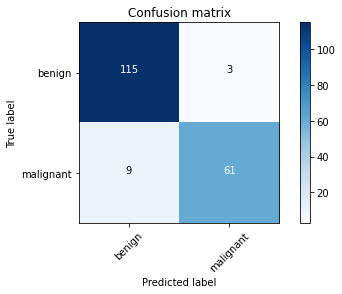

In [45]:
cm_minimum_risk = confusion_matrix(y_test, y_pred_minimum_risk)

class_names = ['benign', 'malignant']

plot_confusion_matrix(cm_minimum_risk, class_names)

In [46]:
tp = cm_minimum_risk[1, 1]
tn = cm_minimum_risk[0, 0]
fp = cm_minimum_risk[0, 1]
fn = cm_minimum_risk[1, 0]

In [47]:
acc = (tp + tn) / (tp + tn + fp + fn)
tpr = tp / (tp + fn)
tnr = tn / (tn + fp)


print(f'Accuracy:\t{acc:.3f}')
print(f'Error Rate:\t{1-acc:.3f}')
print(f'Sensitivity:\t{tpr:.3f}')
print(f'Specificity:\t{tnr:.3f}')

Accuracy:	0.936
Error Rate:	0.064
Sensitivity:	0.871
Specificity:	0.975


## Teil 4: Die Two-Class Support Vector Machine, eine komplexere Alternative

SVMs, bereits in der theoretischen Abhandlung vorgestellt, können unter anderem auf binäre Klassifikationsaufgaben angepasst werden. Der grundsätzliche Ablauf dieser Modellierung läuft dabei analog zur dargestellten Vorgehensweise für den GNB ab.
Folgende Schritte müssen also vollzogen werden, um ein korrektes Training des Modells zu gewährleisten:

* Ausgegangen wird von präprozessierten und (wichtig!) skalierten Daten.
* Aufteilung des Datensatzes in Trainings-, und Testdatenset.
* Definition der Hyperparameter (C, Kernelfunktion, etc.) der Support Vector Machine.
* Start des Trainings per `fit()` Methode.
* Anwenden des trainierten Modells auf Basis ungesehener Daten mittels `predict()`.
* Berechnung von Performancemetriken (Confusionmatrix, Accuracy, Sensitivity, Specificity ...) und damit verbundene Evaluierungen


In [48]:
X_train_sc.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
435,-0.040381,0.033897,-0.031333,-0.156492,0.688694,0.190037,0.289369,0.400686,-0.538702,0.374258,...,0.153872,0.786039,0.194832,-0.023754,1.209232,0.650305,0.622595,1.013328,0.402666,1.159640
47,-0.269157,-0.186397,-0.242351,-0.340508,1.363210,0.371827,0.411614,0.622347,1.134346,0.697609,...,-0.129022,0.324821,-0.135444,-0.217730,1.928369,1.025721,1.062782,1.403381,1.511097,1.829953
326,-0.003664,-1.512751,-0.076082,-0.108290,-0.199878,-0.927414,-0.871345,-0.542068,-1.617617,-0.797022,...,-0.157931,-1.285396,-0.266365,-0.234498,-0.170847,-0.893420,-1.039639,-0.836806,-1.256139,-0.714532
307,-1.446933,-1.163952,-1.458374,-1.157949,-1.785679,-1.333659,-1.042109,-1.145077,-0.104949,0.775324,...,-1.361986,-0.950406,-1.382162,-1.054177,-1.396706,-1.261177,-1.219800,-1.509460,0.113643,-0.324778
551,-0.845336,0.681011,-0.837225,-0.783395,-0.022990,-0.391691,-0.497398,-0.662377,0.777137,0.385360,...,-0.882718,0.374989,-0.879310,-0.787481,-0.977279,-0.470921,-0.554212,-0.758646,0.387292,-0.201526


In [49]:
y_train.head()

435    1
47     1
326    0
307    0
551    0
Name: diagnosis, dtype: int64

In [50]:
twoclass_svm = SVC(kernel='poly', degree=3)

In [51]:
twoclass_svm.fit(X_train_sc, y_train)

SVC(kernel='poly')

In [52]:
y_pred_svm = twoclass_svm.predict(X_test_sc)

In [53]:
acc = accuracy_score(y_test, y_pred_svm)

print(f'Accuracy bzw. Genauigkeit:\t{acc:.3f}')

Accuracy bzw. Genauigkeit:	0.878


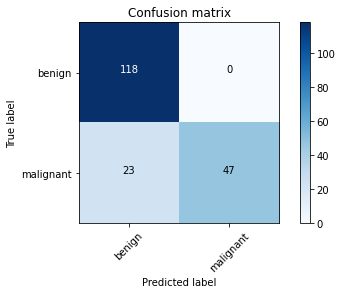

In [54]:
cm_svm = confusion_matrix(y_test, y_pred_svm)

class_names = ['benign', 'malignant']

plot_confusion_matrix(cm_svm, class_names)

In [55]:
tp = cm_svm[1, 1]
tn = cm_svm[0, 0]
fp = cm_svm[0, 1]
fn = cm_svm[1, 0]

In [56]:
acc = (tp + tn) / (tp + tn + fp + fn)
tpr = tp / (tp + fn)
tnr = tn / (tn + fp)


print(f'Accuracy:\t{acc:.3f}')
print(f'Error Rate:\t{1-acc:.3f}')
print(f'Sensitivity:\t{tpr:.3f}')
print(f'Specificity:\t{tnr:.3f}')

Accuracy:	0.878
Error Rate:	0.122
Sensitivity:	0.671
Specificity:	1.000


### Einschub: PCA und die Visualisierung der gelernten Entscheidungsgrenzen von SVMs
Um Ihnen einen Eindruck dessen zu vermitteln, wie eine SVM einen gegebenen Datenraum aufteilt und damit die Klassifikation ungesehener Daten ermöglicht, bedienen wir uns der Principal Component Analysis (PCA). Bei der PCA handelt es sich um einen Algorithmus zur Dimensionsreduktion bei dem die Ursprungsdaten in ein neues Koordinatensystem transformiert werden. Die erste Achse (PC1) dieses neuen Koordinatensystems ergibt sich dabei aus jenem Richtungsvektor, in dem die Daten die größte Varianz aufweisen. Auch alle nachfolgenden Achsen (PC2-PCn), zu Visualisierungszwecken wird typischerweise wird auf 2D bzw. 3D reduziert, berechnen sich auf Basis dieser Varianz.

[StatQuest](https://www.youtube.com/watch?v=FgakZw6K1QQ) bietet ein einsteigerfreundliches (englisches) Tutorial zu dieser Thematik.

Im dimensionsreduzierten Raum sehen wir uns dann genau an, welche Teilbereiche den jeweiligen Klassen 0 und 1 zugeordnet werden, um so ein besseres Verständnis der Funktionsweise von SVMs zu bekommen.

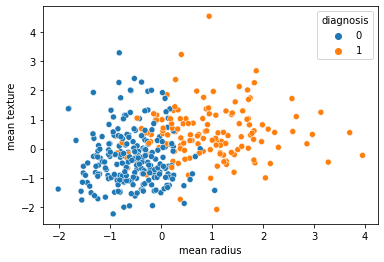

In [57]:
sns.scatterplot(data=X_train_sc, x="mean radius", y="mean texture", hue=y_train);

In [58]:
pca = PCA(n_components=2)

In [60]:
X_train_sc_pca = pca.fit_transform(X_train_sc)
X_test_sc_pca = pca.transform(X_test_sc)

In [61]:
pca.explained_variance_

array([13.13719106,  5.79560602])

In [62]:
twoclass_svm = SVC(gamma='auto', kernel='poly', degree=3,
                   class_weight={
                       0: 1, 1: 5
                   })

In [63]:
twoclass_svm.fit(X_train_sc_pca, y_train)

SVC(class_weight={0: 1, 1: 5}, gamma='auto', kernel='poly')

In [64]:
y_pred_svm = twoclass_svm.predict(X_test_sc_pca)

In [65]:
acc = accuracy_score(y_test, y_pred_svm)

print(f'Accuracy bzw. Genauigkeit:\t{acc:.3f}')

Accuracy bzw. Genauigkeit:	0.894


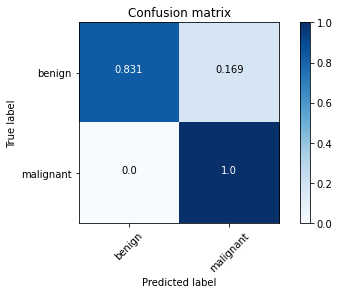

In [66]:
cm_svm = confusion_matrix(y_test, y_pred_svm)

class_names = ['benign', 'malignant']

plot_confusion_matrix(cm_svm, class_names, normalize=True)

In [67]:
tp = cm_svm[1, 1]
tn = cm_svm[0, 0]
fp = cm_svm[0, 1]
fn = cm_svm[1, 0]

In [68]:
acc = (tp + tn) / (tp + tn + fp + fn)
tpr = tp / (tp + fn)
tnr = tn / (tn + fp)


print(f'Accuracy:\t{acc:.3f}')
print(f'Error Rate:\t{1-acc:.3f}')
print(f'Sensitivity:\t{tpr:.3f}')
print(f'Specificity:\t{tnr:.3f}')

Accuracy:	0.894
Error Rate:	0.106
Sensitivity:	1.000
Specificity:	0.831


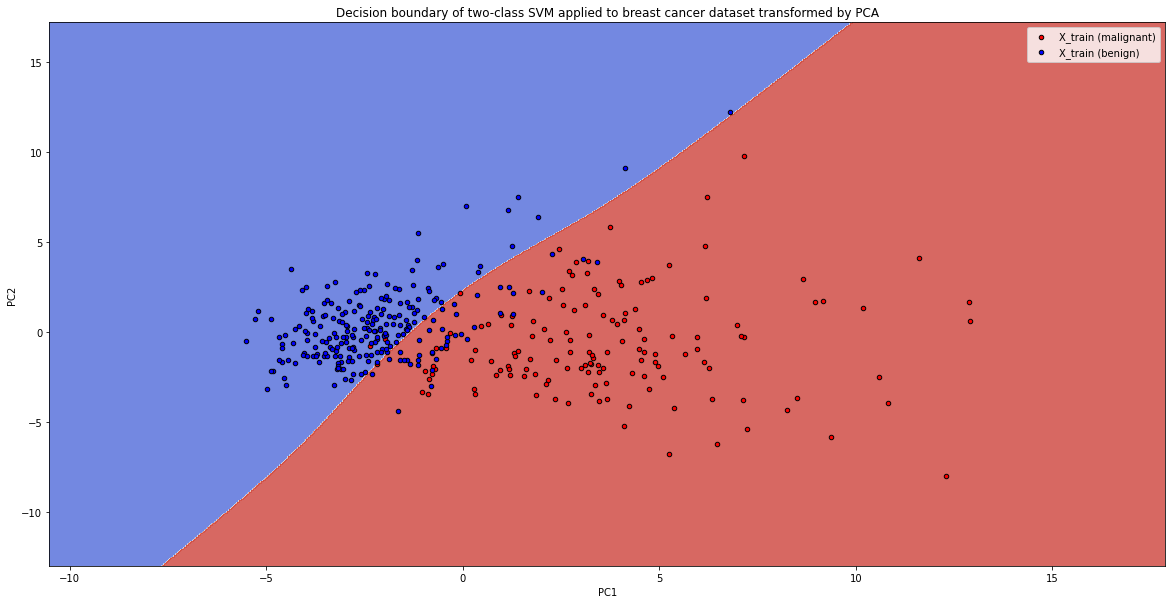

In [69]:
plt.rcParams["figure.figsize"] = (20,10) #globally increase figure size
fig, ax = plt.subplots()
xx, yy = make_meshgrid(X_train_sc_pca[:, 0], X_train_sc_pca[:, 1])

plot_contours(ax, twoclass_svm, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X_train_sc_pca[y_train==1, 0], X_train_sc_pca[y_train==1, 1],
           c="Red", s=20, edgecolors='k', label='X_train (malignant)')
ax.scatter(X_train_sc_pca[y_train==0, 0], X_train_sc_pca[y_train==0, 1],
           c="Blue", s=20, edgecolors='k', label='X_train (benign)')
# ax.scatter(X_test_sc_pca[y_test==1, 0], X_test_sc_pca[y_test==1, 1],
#            c="Orange", s=20, edgecolors='k', label='X_test (malignant)')
# ax.scatter(X_test_sc_pca[y_test==0, 0], X_test_sc_pca[y_test==0, 1],
#            c="Lightblue", s=20, edgecolors='k', label='X_test (benign)')
ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
ax.legend()
ax.set_title('Decision boundary of two-class SVM applied to breast cancer dataset transformed by PCA')
plt.show()
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"] #reset figure size increase

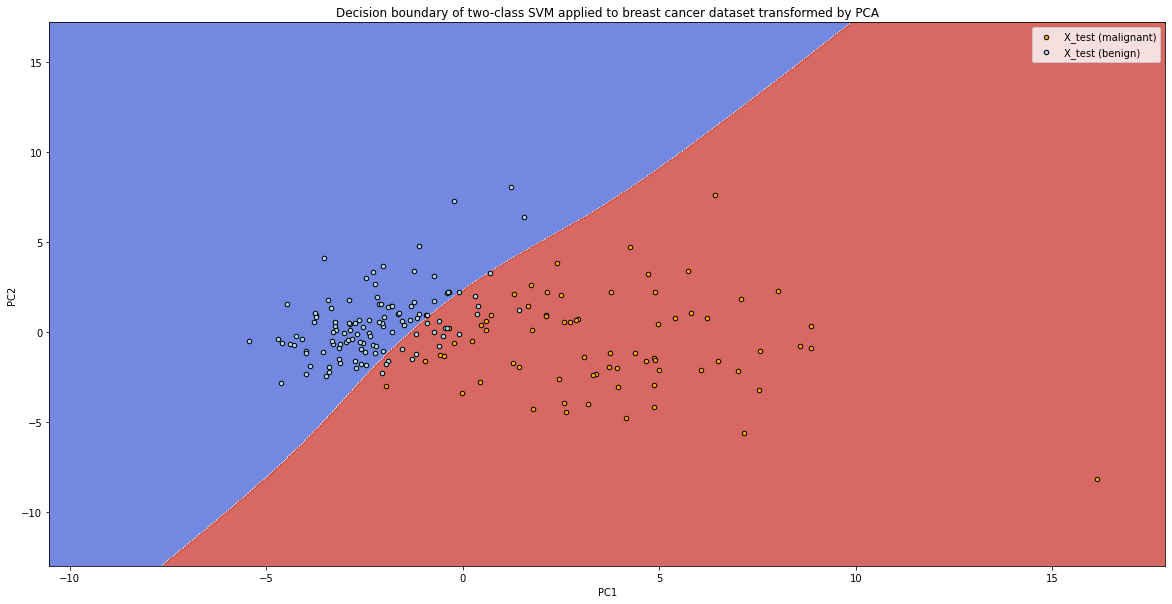

In [70]:
plt.rcParams["figure.figsize"] = (20,10) #globally increase figure size
fig, ax = plt.subplots()
xx, yy = make_meshgrid(X_train_sc_pca[:, 0], X_train_sc_pca[:, 1])

plot_contours(ax, twoclass_svm, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
# ax.scatter(X_train_sc_pca[y_train==1, 0], X_train_sc_pca[y_train==1, 1],
#            c="Red", s=20, edgecolors='k', label='X_train (malignant)')
# ax.scatter(X_train_sc_pca[y_train==0, 0], X_train_sc_pca[y_train==0, 1],
#            c="Blue", s=20, edgecolors='k', label='X_train (benign)')
ax.scatter(X_test_sc_pca[y_test==1, 0], X_test_sc_pca[y_test==1, 1],
           c="Orange", s=20, edgecolors='k', label='X_test (malignant)')
ax.scatter(X_test_sc_pca[y_test==0, 0], X_test_sc_pca[y_test==0, 1],
           c="Lightblue", s=20, edgecolors='k', label='X_test (benign)')
ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
ax.legend()
ax.set_title('Decision boundary of two-class SVM applied to breast cancer dataset transformed by PCA')
plt.show()
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"] #reset figure size increase

## Teil 5: Neuronale Netze zur Binärklassifikation strukturierter Daten
<br>
<br>
<br>
<br>
<center><img src="../resources/images/neural_network_0.png" width="500px"/></center>
<center>Fig. 2: <a href="https://www.researchgate.net/publication/303875065_ASSESSMENT_OF_ARTIFICIAL_NEURAL_NETWORK_FOR_BATHYMETRY_ESTIMATION_USING_HIGH_RESOLUTION_SATELLITE_IMAGERY_IN_SHALLOW_LAKES_CASE_STUDY_EL_BURULLUS_LAKE">researchgate.net</a></center>
<br>
<br>
Die grundsätzliche Funktionsweise eines neuronalen Netzes, bestehend aus mehreren Schichten sog. Perzeptronen, illustriert Fig. 2. Wie ein solches Netz in [TensorFlow](https://www.tensorflow.org/api_docs/python/tf) in Verbindung mit [Keras](https://keras.io/api/)] umgesetzt wird, sehen wir uns nach dem Review unserer Daten an.

### Vorverarbeitung der Daten
Einfache neuronale Netze (NN) setzen es voraus, Daten in Form eines Vektors übergeben zu bekommen (vgl. Fig. 2 Input #1 - Input #4).
Diese Anforderungen erfüllt unser Datensatz bereits, ebenso sind die darin enthaltenen Daten korrekt skaliert.
Spezielle Anforderungen hat das NN auch an die Labels zu den einzelnen Samples (=eine Zeile in **X**): so ist eine Konvertierung dieser Labels in einen sog. One-Hot-Vector vorzunehmen. Dieser Umstand ergibt sich aus der Eigenschaft unseres Beispielnetzes, Pseudowahrscheinlichkeiten für die möglichen Klassen unseres Datensatzes (0: benign, 1: malignant) zu errechnen (vgl. Gaussian Naive Bayes Classifier). Diese Pseudowahrscheinlichkeiten gilt es im letzten Schritt der Klassifizierung, also im Teil der Netzperformanceevaluierung, zu den finalen Prädiktionen des Netzes zu konvertieren.

Abschließend ist es auch für neuronale Netze notwendig, einen Teil unseres Datensatzes (**X_test** und **y_test**) für die eben angesprochene finale Evaluierung der Modellperformance beiseite zu legen.

In [ ]:
X_train_sc.head()

In [ ]:
y_train.head()

In [ ]:
y_train_onehot = pd.get_dummies(y_train)

In [ ]:
y_train_onehot.head()

In [ ]:
y_test_onehot = pd.get_dummies(y_test)

In [ ]:
X_train_sc.shape

### Konfiguration eines neuronalen Netzes

Nachdem der Schritt der Datenvorverarbeitung nun abgeschlossen ist, kümmern wir uns um die Konfiguration unseres neuronalen Netzes. In unserem Beispiel ist es zwingend erforderlich, folgende Parameter zu setzen:

- Dimensionalität der **Input-Schicht**
- Dimensionalität des **Output-Schicht**
- **Anzahl der verborgenen Schichten** im neuronalen Netz
- Anzahl der **Perzeptronen pro verborgener Schicht**
- Wahl der **Übertragungsfunktion** pro verborgener Schicht und für die Output-Schicht
- Wahl einer **loss function** (zu dt. "Verlustfunktion") und eines sog. **optimizers**, die zur Minimierung des Fehlers verwendet werden.

In [ ]:
# define model
model = Sequential()
model.add(Dense(16, input_dim=X_train_sc.shape[1], activation='relu'))
model.add(Dense(2, activation='softmax'))

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

### Trainieren des Modells
Wie bereits aus dem letzten Workshop bekannt, startet ein Aufruf der Methode `fit()` eines Modells das Training.
Die Untersuchung des Trainingsfortschritts erfolgt auf Basis der sog. "Learning Curve". TensorFlow bietet hierfür eine komfortable Auswertungsmethode in der Form des Moduls [TensorBoard](https://www.tensorflow.org/tensorboard) an. Dieses Modul wird bei Installation von TensorFlow bereits mitgeliefert und lässt sich, nach entsprechender Instanzierung im Code und Übergabe an die `fit()` Methode per CLI starten:

`tensorboard --logdir logs --host 0.0.0.0`

Die Visualisierung der Trainingsperformance ihrer neuronalen Netze wird dann über ein entsprechendes Dashboard auf [http://localhost:6006](http://localhost:6006) angezeigt.

In [ ]:
tensorboard = TensorBoard(log_dir="..\\logs\\BC_Classification" + datetime.now().strftime("%Y%m%d-%H%M%S"))
early_stopping = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, verbose=1)

model.fit(X_train_sc, y_train_onehot,
          epochs = 256,
          batch_size = 32,
          validation_split = 0.3,
          verbose = 1,
          callbacks = [tensorboard, early_stopping]);

### Evaluierung der Modellperformance
Unser erstes neuronales Netz hat natürlich, wie bereits erwähnt, auch auf ungesehene Daten entsprechend zu performen.
Die entsprechenden Untersuchungen werden, wie schon für GNB und SVM, auf Basis der bewährten Confusion Matrix unternommen,
wobei natürlich nur jene Daten herangezogen werden dürfen, die aus dem Trainingsprozess herausgehalten wurden.

In [ ]:
y_pred_proba = model.predict(X_test_sc)

In [ ]:
y_pred_proba_df = pd.DataFrame(y_pred_proba,
                               columns=y_test_onehot.columns,
                               index=y_test_onehot.index)

In [ ]:
y_pred_proba_df.head()

In [ ]:
y_pred_mlp = np.argmax(y_pred_proba_df.values, axis=-1)

In [ ]:
acc = accuracy_score(y_test, y_pred_mlp)

print(f'Accuracy bzw. Genauigkeit:\t{acc:.3f}')

In [ ]:
cm_mlp = confusion_matrix(y_test, y_pred_mlp)

class_names = ['benign', 'malignant']

plot_confusion_matrix(cm_mlp, class_names, normalize=True)

In [ ]:
tp = cm_mlp[1, 1]
tn = cm_mlp[0, 0]
fp = cm_mlp[0, 1]
fn = cm_mlp[1, 0]

In [ ]:
acc = (tp + tn) / (tp + tn + fp + fn)
tpr = tp / (tp + fn)
tnr = tn / (tn + fp)


print(f'Accuracy:\t{acc:.3f}')
print(f'Error Rate:\t{1-acc:.3f}')
print(f'Sensitivity:\t{tpr:.3f}')
print(f'Specificity:\t{tnr:.3f}')

### Erster Durchlauf: abgeschlossen!

<center><img src="../resources/images/crisp_dm.png" width="512px"/></center>
<center>Fig. 4 <a href="https://mineracaodedados.files.wordpress.com/2012/04/the-crisp-dm-model-the-new-blueprint-for-data-mining-shearer-colin.pdf">CRISP-DM Modell (Shearer 2000)</a></center>

Zum Abschluss rufen wir uns noch einmal das CRISP-DM Modell (Fig. 4) in Erinnerung, das den typischen Ablauf eines Data Science Projekts aufzeigt. Diese Grafik legt uns nun nahe, nach einem ersten Versuch der Modellierung an den Anfang unseres Projektes zurückzugehen, noch einmal an allen uns zur Verfügung stehenden Stellschrauben zu drehen, um so die Modellperformance zu verbessern.